In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from hyperopt import hp, fmin, tpe, Trials
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Read parquet file as dataframe
df = pd.read_parquet('bert_transformed.parquet')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209056 entries, 0 to 209526
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   category          209056 non-null  object
 1   text              209056 non-null  object
 2   reduced_category  209056 non-null  object
 3   embeddings        209056 non-null  object
dtypes: object(4)
memory usage: 8.0+ MB


In [3]:
# Faltten embeddings to prepare for modeling
embedding_cols = [f"embeddings_{i}" for i in range(768)] 

# Convert the embeddings to Dataframe
embedding_df = pd.DataFrame(df['embeddings'].tolist(), index=df.index, columns=embedding_cols)

# Concatenate the new columns with the original DataFrame
df = pd.concat([df, embedding_df], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 209056 entries, 0 to 209526
Columns: 772 entries, category to embeddings_767
dtypes: float32(768), object(4)
memory usage: 620.4+ MB


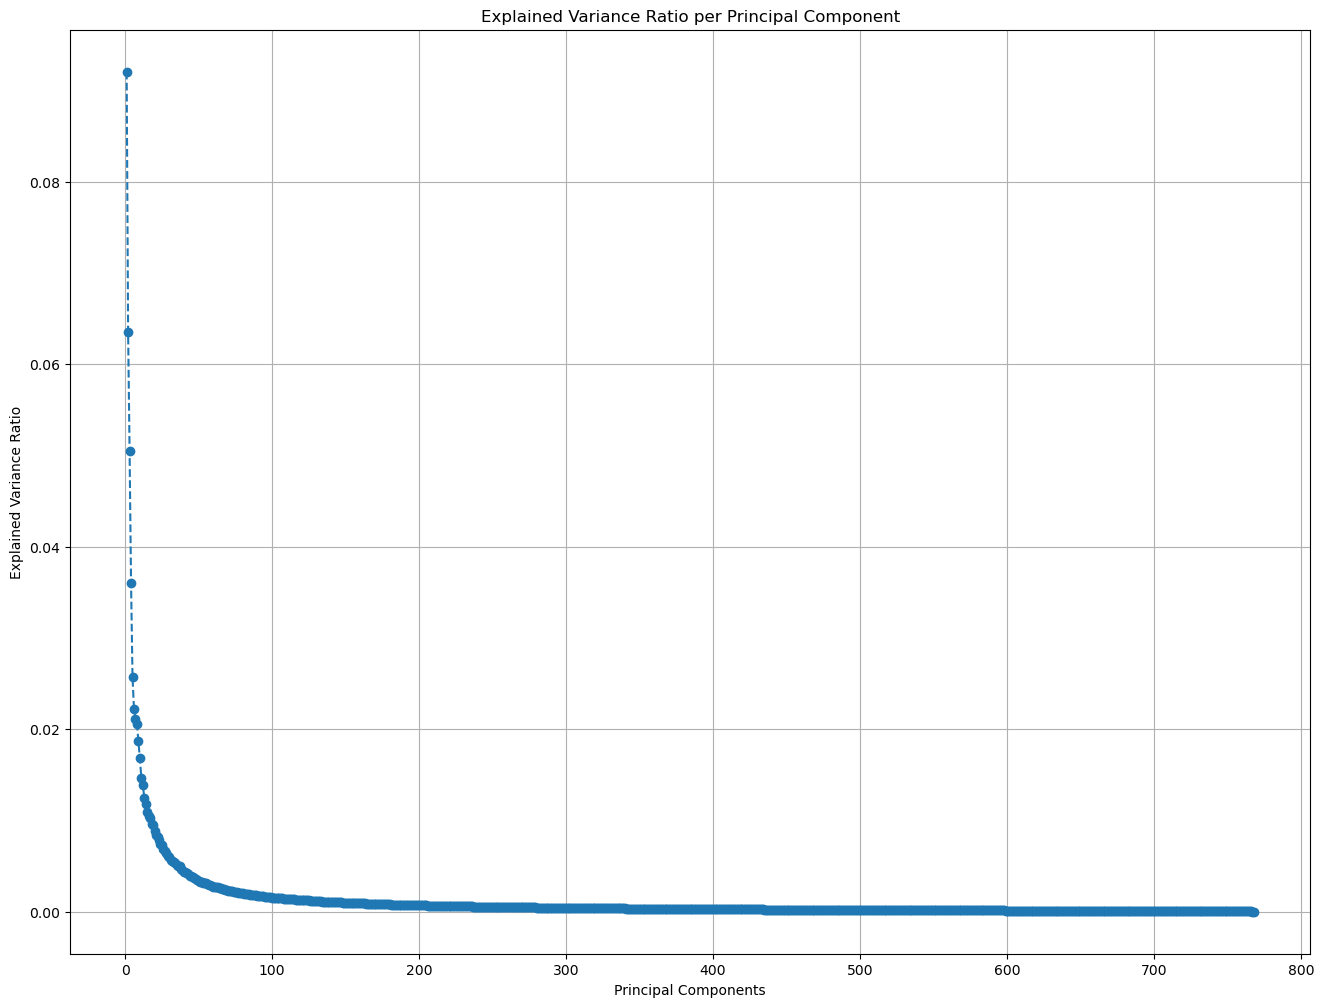

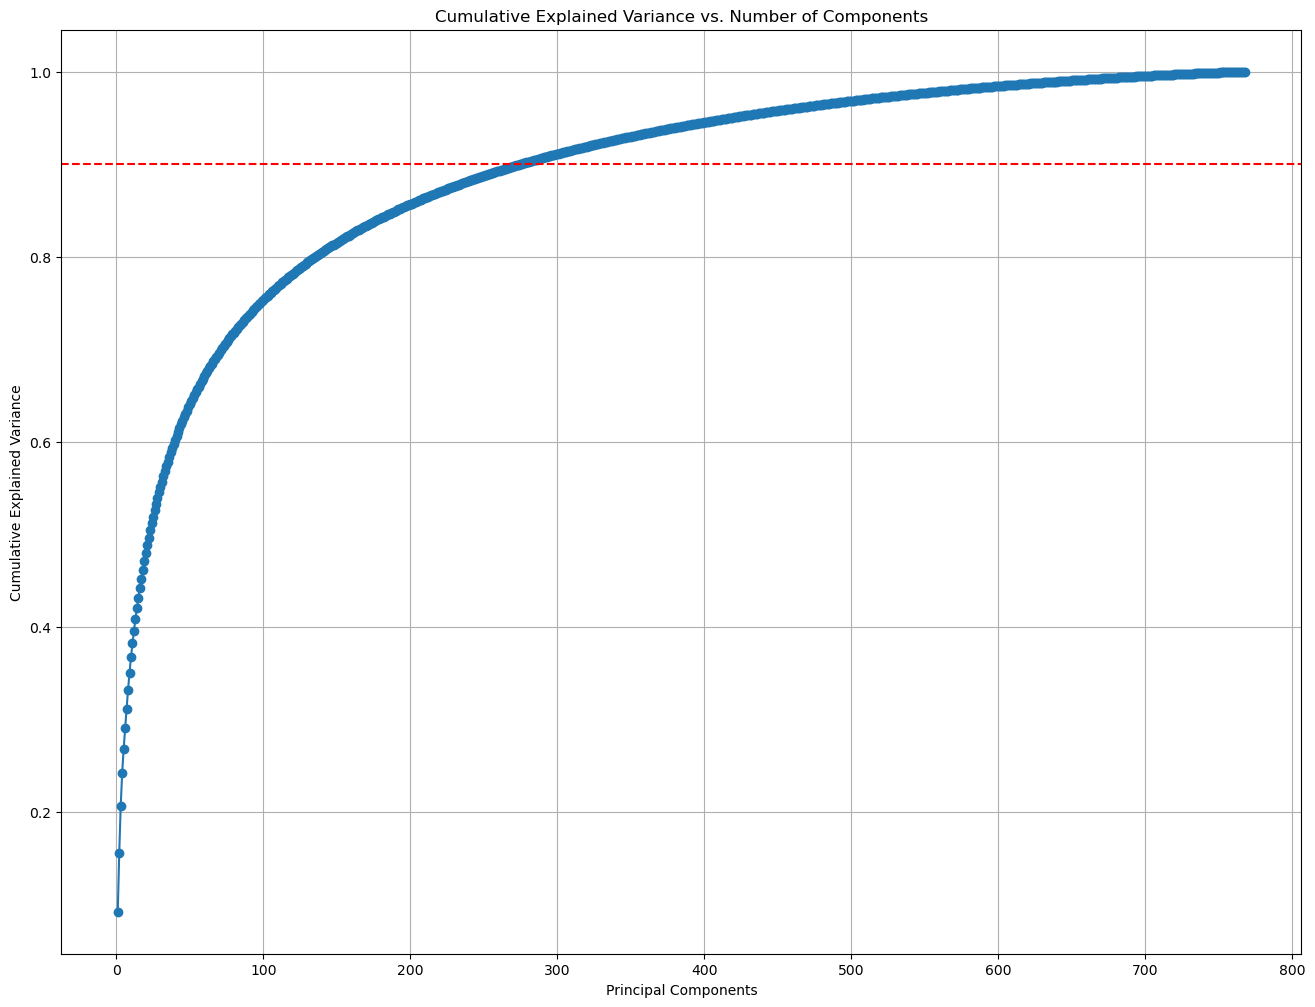

Optimal number of components to retain 90.0% variance: 275


,category,text,reduced_category,pca_component_1,pca_component_2,pca_component_3,pca_component_4,pca_component_5,pca_component_6,pca_component_7,...,pca_component_266,pca_component_267,pca_component_268,pca_component_269,pca_component_270,pca_component_271,pca_component_272,pca_component_273,pca_component_274,pca_component_275
0,U.S. NEWS,Over 4 Million Americans Roll Up Sleeves For O...,News,2.025210,0.973063,-0.301316,-2.316024,-1.467288,0.460809,-1.504096,...,-0.072174,0.026701,0.008475,-0.206956,-0.088534,0.017795,0.005720,-0.186113,-0.090920,-0.108102
1,U.S. NEWS,"American Airlines Flyer Charged, Banned For Li...",News,2.070798,-2.280283,-1.832026,-0.976248,-0.739679,1.734097,-0.591243,...,-0.167262,-0.026612,0.055114,0.158755,-0.043546,0.039385,-0.188812,-0.036071,0.125888,0.109777
2,COMEDY,23 Of The Funniest Tweets About Cats And Dogs ...,Entertainment,-0.523807,0.631577,-1.282917,2.066625,0.026843,0.032549,1.696045,...,0.223431,-0.024267,-0.135269,-0.234656,0.169727,0.204474,0.151722,0.109246,0.005746,-0.165035
3,PARENTING,The Funniest Tweets From Parents This Week (Se...,Lifestyle,-0.313406,-2.137994,0.749387,1.619455,-0.236968,-0.540043,1.085353,...,0.128345,-0.058536,-0.008744,-0.052174,0.085499,0.246729,0.153603,0.086838,-0.097719,-0.253115
4,U.S. NEWS,Woman Who Called Cops On Black Bird-Watcher Lo...,News,3.992092,-1.672859,-0.080477,0.185022,-0.876319,1.157343,1.402102,...,0.156056,0.036726,0.049320,0.201582,0.042022,0.015834,-0.282499,-0.175405,0.246151,0.187436


In [4]:
# Perform dimension reduction with PCA

# Initialize global variables
threshold = 0.9

# Transform embeddings into numpy array
embeddings_matrix = embedding_df.values

# Fit PCA and calculate explained variance ratio for different components
pca = PCA()
pca.fit(embeddings_matrix)
explained_variance_ratio = pca.explained_variance_ratio_

# Plot explained variance ratio (Elbow method)
plt.figure(figsize=(16, 12))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Explained Variance Ratio per Principal Component')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.grid(True)
plt.show()

# Step 5: Plot cumulative explained variance to identify the optimal number of components
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
plt.figure(figsize=(16, 12))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.axhline(y=threshold, color='r', linestyle='--')  # Threshold for 95% variance
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Identify the optimal number of components
optimal_components = np.argmax(cumulative_explained_variance >= threshold) + 1
print(f"Optimal number of components to retain {threshold * 100}% variance: {optimal_components}")

# Apply PCA to reduce to the optimal number of components
pca = PCA(n_components=optimal_components)
reduced_embeddings = pca.fit_transform(embeddings_matrix)

# Create a dataframe with the reduced embeddings
reduced_embedding_cols = [f"pca_component_{i+1}" for i in range(optimal_components)]
reduced_embedding_df = pd.DataFrame(reduced_embeddings, columns=reduced_embedding_cols, index=embedding_df.index)

# Concatenate the reduced embeddings back to the original dataframe and drop the original embedding columns
df = pd.concat([df, reduced_embedding_df], axis=1)
df = df.drop(columns=embedding_cols)
df = df.drop(columns=['embeddings'])

df.head()

In [10]:
# Initialize test and training dataset split
X = df.drop(columns=['category', 'reduced_category', 'text'])  # Drop the target column (labels)
y = df['reduced_category']  # The target column

In [11]:
# Initialize number of folds and dictionary to store metrics
k = 5

results = {
    'Model': [],
    'Accuracy': [],
    'Accuracy SD': [],
    'Precision': [],
    'Precision SD': [],
    'Recall': [],
    'Recall SD': [],
    'F1-Score': [],
    'F1-Score SD': [],
}

In [17]:
# Define metric computing functions
def compute_metrics(y_test, y_pred):
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, average='weighted'),
        'recall': recall_score(y_test, y_pred, average='weighted'),
        'f1': f1_score(y_test, y_pred, average='weighted')
    }
    return metrics

def append_metrics(result, model_name, accuracies, precisions, recalls, f1s):
    results['Model'].append(model_name)
    results['Accuracy'].append(np.mean(accuracies))
    results['Accuracy SD'].append(np.std(accuracies))
    results['Precision'].append(np.mean(precisions))
    results['Precision SD'].append(np.std(precisions))
    results['Recall'].append(np.mean(recalls))
    results['Recall SD'].append(np.std(recalls))
    results['F1-Score'].append(np.mean(f1s))
    results['F1-Score SD'].append(np.std(f1s))

def plot_confusion_matrix(avg_cm, model_name, k):
    plt.figure(figsize=(6, 5))
    sns.heatmap(avg_cm, annot=True, fmt="d", cmap="Blues", xticklabels=y.unique(), yticklabels=y.unique())
    plt.title(f"Average Confusion Matrix for {model_name} ({k}-fold CV)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [ ]:
# Implement GridSearch to optimize hyperparameter C for l1 penalty

# Initialize parameter grid
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
# Randomly split set into training and test set for grid search
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize GridSearchCV with 5-fold cross-validation
grid_search = GridSearchCV(estimator=LogisticRegression(solver='liblinear'), param_grid=param_grid, cv=5, scoring='accuracy')

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best hyperparameter C
optimal_C = grid_search.best_params_['C']
optimal_C

Average Accuracy across 5-folds: 0.7208


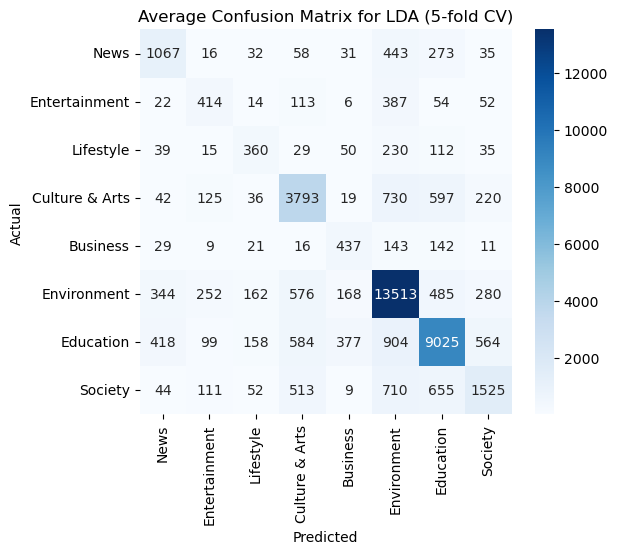

In [18]:
# Initialize hyperparameters and models
kf = KFold(n_splits=k, shuffle=True, random_state=32)
model = LinearDiscriminantAnalysis()
model_name = "LDA"

# Create lists to store metrics from each fold
accuracies = []
precisions = []
recalls = []
f1s = []
confusion_matrices = []


# Loop through each fold
for train_index, test_index in kf.split(X): 
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the Quadratic Discriminant Analysis model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics for this fold and append it to metric list
    accuracy = compute_metrics(y_test, y_pred)['accuracy']
    precision = compute_metrics(y_test, y_pred)['precision']
    recall = compute_metrics(y_test, y_pred)['recall']
    f1 = compute_metrics(y_test, y_pred)['f1']

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    # Compute confusion matrix for this fold
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices.append(cm)

# Calculate average accuracy across all folds
print(f"Average Accuracy across {k}-folds: {np.mean(accuracies):.4f}")

# Store all average metrics in final table
append_metrics(results, model_name, accuracies, precisions, recalls, f1s)

# Calculate the average confusion matrix
avg_cm = np.mean(confusion_matrices, axis=0).astype(int)

# Plot Confusion Matrix as Heatmap (average confusion matrix)
plot_confusion_matrix(avg_cm, model_name, k)

In [19]:
# Model comparison results
results_df = pd.DataFrame(results)
print("Overall Model Performance Comparison over " + str(k) + " folds")
results_df

Overall Model Performance Comparison over 5 folds


,Model,Accuracy,Accuracy SD,Precision,Precision SD,Recall,Recall SD,F1-Score,F1-Score SD
0,LDA,0.720788,0.001873,0.7188,0.002459,0.720788,0.001873,0.717971,0.002121
1,LDA,0.720788,0.001873,0.7188,0.002459,0.720788,0.001873,0.717971,0.002121
